<a href="https://colab.research.google.com/github/MLUISG/Projects/blob/main/Mark_Guereque_Project_5_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5 
This project is split into two parts. In the first part I will pull data from a CSV file, select one person as the input to output 10 others who are deemed 'closest' via NLP.

##Imports

In [1]:
#install Wikipedia API
%%capture
!pip3 install wikipedia-api


In [2]:
import numpy as np
import array
import pandas as pd
import wikipediaapi
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer as BagOfWords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
pd.options.display.max_columns = 100

#Part 1

##Data Mounting

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
data_path = '/content/drive/My Drive/Project 5/Data/Project_5.csv'
master_data = pd.read_csv(data_path)

##Data Overview

In [5]:
master_data.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [6]:
master_data.shape

(42786, 3)

In [7]:
master_data.dtypes

URI     object
name    object
text    object
dtype: object

In [8]:
#Finding my target person
john_index = master_data['name'].str.contains('John Adams')
print(master_data[john_index])

                                                     URI  \
15756  <http://dbpedia.org/resource/John_Adams_(Major...   

                             name  \
15756  John Adams (Major General)   

                                                    text  
15756  john lawrence adams cmm cd born 31 may 1942 wa...  


In [9]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(master_data['text'])

In [10]:
n_neighbors = 12 # 11 neighbors + John Adams himself
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(tfidf_matrix)
distances, indices = knn.kneighbors(tfidf_matrix[john_index])

In [11]:
#Made a list of 11 because I know I'm gonna drop one
closest_neighbors = []
for i in range(1, n_neighbors):
    closest_neighbors.append(master_data.iloc[indices[0][i]]['name'])
print("11 closest neighbors to John Adams:", closest_neighbors)

11 closest neighbors to John Adams: ['H. Ian Macdonald', 'L%C3%A9onard Legault', 'Ian Fraser (colonel)', 'Clive M. Law', 'Christopher McCreery', 'Stefan Wallin', 'Evan Adams', 'James C. Card', 'Stanley Adams (whistleblower)', 'Kevin S. MacLeod', 'Robert Watt']


In [12]:
#My search function
search = master_data['name'].str.contains('Christopher McCreery')
master_data[search].iloc[0,0].replace('<','').replace('>','')

'http://dbpedia.org/resource/Christopher_McCreery'

In [13]:
#Removed McCreery becaues there isn't any info on him.
closest_neighbors.remove('Christopher McCreery')

In [14]:
#Create a list to append in and save for future use
neighbor_sentiments = []
print("Sentiment scores of John Adams' neighbors:")
for neighbor_name in closest_neighbors:
    neighbor_index = master_data.index[master_data['name'] == neighbor_name][0]
    neighbor_text = master_data.loc[neighbor_index, 'text']
    neighbor_text_clean = neighbor_text.replace("\n"," ").replace("\'s",'').replace('\'','')
    neighbor_sentiment = TextBlob(neighbor_text_clean).sentiment.polarity
    neighbor_sentiments.append(neighbor_sentiment)
    print(neighbor_name, neighbor_sentiment)

Sentiment scores of John Adams' neighbors:
H. Ian Macdonald 0.0
L%C3%A9onard Legault 0.1647208931419458
Ian Fraser (colonel) 0.025313283208020048
Clive M. Law 0.053947368421052605
Stefan Wallin 0.04863945578231293
Evan Adams 0.15800000000000003
James C. Card 0.14583333333333334
Stanley Adams (whistleblower) -0.0225
Kevin S. MacLeod 0.012445887445887448
Robert Watt 0.17954545454545454


In [15]:
#Trying to make array from list
CSV_array = np.array(neighbor_sentiments)
CSV_array

array([ 0.        ,  0.16472089,  0.02531328,  0.05394737,  0.04863946,
        0.158     ,  0.14583333, -0.0225    ,  0.01244589,  0.17954545])

#Part 2
In the second part I will pull sentiment data using the WikiAPI and compare them to the CSV sentiment data using the same people.

In [16]:
# Pull out the John Adams page from wikipedia - https://en.wikipedia.org/wiki/John_Adams_(Canadian_general)
topic = 'John Adams (Canadian general)'
wikip = wikipediaapi.Wikipedia('en')
page_ex = wikip.page(topic)
wiki_text = page_ex.text
wiki_text_clean = wiki_text.replace("\n"," ").replace("\'s",'').replace('\'','')
wiki_text_clean

'John Lawrence Adams, , (born May 31, 1942) was the Chief of the Communications Security Establishment Canada and Associate Deputy Minister of National Defence from July 2005 to January 2012. He was succeeded by John Forster. Adams graduated from the Royal Military College of Canada, earning a Bachelor of Engineering degree in chemical engineering in 1965. Adams is also a Rhodes Scholar after graduating, in 1967, with a Bachelor of Arts degree from Oxford University, in England, in 1967. He also graduated from the Army Staff College as well as the National Defence College. Adams joined the Canadian Forces in 1967 and served until 1993. He took on many roles, from command of 1 Combat Engineer Regiment in Chilliwack, British Columbia (CFB Chilliwack) to posts at National Defence Headquarters. He retired with the rank of Major-General. After his retirement from the Canadian Forces, Adams was appointed Assistant Deputy Minister, Infrastructure and Environment, for National Defence. He left

In [17]:
#Wiki sentiment score
text_sentiment = TextBlob(wiki_text_clean).sentiment.polarity
print("Sentiment score of John Adams' Wikipedia page:", text_sentiment)

Sentiment score of John Adams' Wikipedia page: -0.028571428571428574


In [18]:
#Corrected name in list
closest_neighbors[1] = 'Léonard Legault'

In [19]:
#Ensure all names can be fed to API
closest_neighbors

['H. Ian Macdonald',
 'Léonard Legault',
 'Ian Fraser (colonel)',
 'Clive M. Law',
 'Stefan Wallin',
 'Evan Adams',
 'James C. Card',
 'Stanley Adams (whistleblower)',
 'Kevin S. MacLeod',
 'Robert Watt']

In [20]:
# Initialize an empty list to store the sentiment scores
wiki_sent = []

# Iterate over each topic and retrieve its page text
for i, topic in enumerate(closest_neighbors):
    # Get the Wikipedia page for the current topic
    page_ex = wikip.page(topic)

    # Retrieve the page text and print it with a label
    wiki_text = page_ex.text
    wiki_text_clean = wiki_text.replace("\n"," ").replace("\'s",'').replace('\'','')
    print(f'Page text for person {i+1} "{topic}": {wiki_text_clean}\n')
    
    # Get the sentiment score for the current person's page text
    sentiment_score = TextBlob(wiki_text_clean).sentiment.polarity
    wiki_sent.append(sentiment_score)
    print(f'Sentiment score for person {i+1} "{topic}": {sentiment_score}\n\n')

# Print the list of sentiment scores
print('Sentiment scores:', wiki_sent)

Page text for person 1 "H. Ian Macdonald": Hugh Ian Macdonald, OC, KLJ (born June 27, 1929) is a Canadian economist, civil servant, and was President of York University from 1974 to 1984.  Biography Born in Toronto, Ontario, Macdonald received a Bachelor of Commerce degree from the University of Toronto in 1952. A Rhodes scholar, he received a Master of Arts degree in 1954 and a Bachelor of Philosophy (Economics) degree in 1955. In 1955, he started teaching at the University of Toronto and became an assistant professor of economics in 1962. In 1965, he became Chief Economist for the Government of Ontario Department of Economics and Development. He later became Deputy Treasurer in 1967, Deputy Minister of Treasury and Economics in 1968, and Deputy Treasurer and Deputy Minister of Economics and Intergovernmental Affairs in 1972. He was president of York University from 1974 to 1984. From 1984 to 1994, he was the Director of York International. From 1994 to 2003, he was the Chairman of th

In [21]:
wiki_array = np.array(wiki_sent)
wiki_array

array([ 0.125     ,  0.14394571,  0.00666667,  0.03207522,  0.03446368,
        0.14107143,  0.14583333, -0.025     ,  0.02763605,  0.15856643])

##Comparison Chart
Here we can compare the sentiment between the original list and the one from the wiki

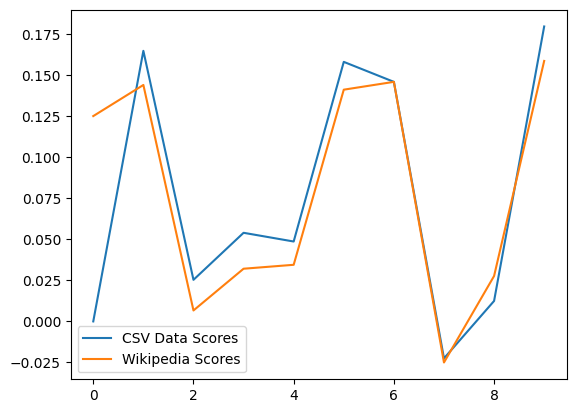

In [22]:
plt.plot(neighbor_sentiments, label='CSV Data Scores')
plt.plot(wiki_sent, label='Wikipedia Scores')
plt.legend()
plt.show()

#Free search

In [37]:
#Add search topic here
topic = "Mercury (planet)"

In [33]:
#Add list here
search_list = 'Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune'.split(',')

In [38]:
#Use this code block to search for subject in WikiAPI
wikip = wikipediaapi.Wikipedia('en')
page_ex = wikip.page(topic)
wiki_text = page_ex.text
wiki_text_clean = wiki_text.replace("\n"," ").replace("\'s",'').replace('\'','')
wiki_text_clean 

'Mercury is the smallest planet in the Solar System and the closest to the Sun. Its orbit around the Sun takes 87.97 Earth days, the shortest of all the Sun planets. It is named after the Roman god Mercuriuscode: lat promoted to code: la  (Mercury), god of commerce, messenger of the gods, and mediator between gods and mortals, corresponding to the Greek god Hermes (Ἑρμῆςcode: ell promoted to code: el ). Like Venus, Mercury orbits the Sun within Earth orbit as an inferior planet; its apparent distance from the Sun as viewed from Earth never exceeds 28°. This proximity to the Sun means the planet can only be seen near the western horizon after sunset or the eastern horizon before sunrise, usually in twilight. At this time, it may appear as a bright star-like object, but is more difficult to observe than Venus. From Earth, the planet telescopically displays the complete range of phases, similar to Venus and the Moon, which recurs over its synodic period of approximately 116 days. Due to i

In [39]:
#Use this code block to search for list of subjects in WikiAPI
for i, topic in enumerate(search_list):
  page_ex = wikip.page(topic)
  wiki_text = page_ex.text
  wiki_text_clean = wiki_text.replace("\n"," ").replace("\'s",'').replace('\'','')
  print(f'Page text for subject {i+1} "{topic}": {wiki_text_clean}\n')

Page text for subject 1 "Mercury": Mercury commonly refers to:  Mercury (planet), the nearest planet to the Sun Mercury (element), a metallic chemical element with the symbol Hg Mercury (mythology), a Roman godMercury or The Mercury may also refer to:  Companies Mercury (toy manufacturer), a brand of diecast toy cars manufactured in Italy Mercury Communications, a British telecommunications firm set up in the 1980s Mercury Drug, a Philippine pharmacy chain Mercury Energy, an electricity generation and retail company in New Zealand Mercury Filmworks, a Canadian independent animation studio Mercury General, a multiple-line American insurance organization Mercury Interactive, a software testing tools vendor Mercury Marine, a manufacturer of marine engines, particularly outboard motors Mercury Systems, a defense-related information technology company  Computing Mercury (programming language), a functional logic programming language Mercury (metadata search system), a data search system for